In [22]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
import os
from functools import reduce
from statsmodels.tsa.stattools import coint

In [23]:
import math
from scipy.stats import norm
from pandas_datareader import data
from yahoo_fin import stock_info as si
import seaborn as sns
from statsmodels.tsa.stattools import coint
import statsmodels.tsa.stattools as ts
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.preprocessing import normalize
import datetime
import numpy as np
import scipy as sp
import scipy.fftpack
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
sns.set(style='white')

### Importing the data:

In [25]:
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%m-%d-%Y")
    d2 = datetime.strptime(d2, "%m-%d-%Y")
    return abs((d2 - d1).days)

start_date='2/1/2010'
end_date='30/12/2019'

XLE=['XOM','CVX','COP','EOG','KMI','SLB','PSX','OXY','MPC','VLO']
XLK=['MSFT','AAPL','V','MA','INTC','CSCO','ADBE','CRM','NVDA','PYPL']
XLB=['LIN','APD','ECL','SHW','DD','NEM','PPG','BLL',]
XLY=['AMZN','HD','MCD','NKE','SBUX','LOW','BKNG','TJX','TGT','GM']
XLU=['NEE','SO','DUK','D','AEP','EXC','SRE','XEL','WEC','ED']
ETF=XLE+XLK+XLB+XLY+XLU
pair=['CVX','XOM','MSFT','AAPL','JNJ','PEP']
df=pd.DataFrame()
df_XLE = pd.DataFrame()
df_XLK = pd.DataFrame()
df_XLB = pd.DataFrame()
df_XLY = pd.DataFrame()
df_XLU = pd.DataFrame()
df_ETF = pd.DataFrame()

In [26]:
for stock in XLU:
    price = data.DataReader(stock,'yahoo',start=start_date,end=end_date)
    s = price['Adj Close']
    df_XLU[stock]= s
df_XLU=df_XLU.dropna()
#df_XLK=df_XLK.tail(91)

## Prescreening of Stock Pairs :

### Step 1: Correlation

Text(0.5, 0.98, 'Pearson Correlations')

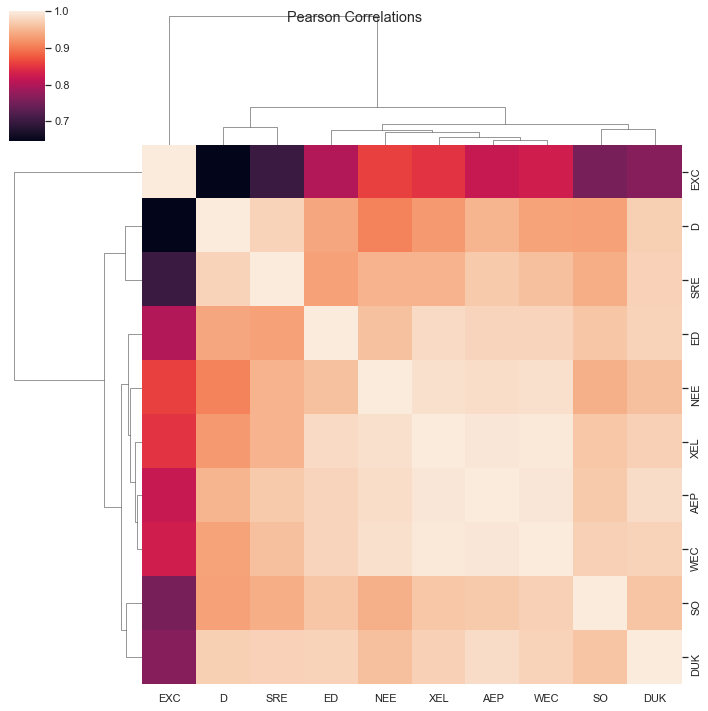

In [27]:
# Correlation test:
# Calculate and plot price correlations.
pearson_corr  = df_XLU.corr()
sns.clustermap(pearson_corr).fig.suptitle('Pearson Correlations')

In [28]:
p1 = 'WEC'
p2 = 'AEP'

### Step 2: Cointegration test:

In [29]:
# Cointegration test:
# Calculate the p-value of cointegration test for pairs.
x1 = np.log(df_XLU[p1])
y1 = np.log(df_XLU[p2])
_, p_value, _ = coint(x1, y1)
print('The p_value of the pair cointegration is: {}'.format(p_value))

The p_value of the pair cointegration is: 0.003653050429964533


In [31]:
def plot_spread(df, ticker1, ticker2, th, stop):
  
    px1 = np.log(df[ticker1])/np.log(df[ticker1][0])
    px2 = np.log(df[ticker2])/np.log(df[ticker2][0])

    sns.set(style='white')
    
    # Set plotting figure
    fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [2, 1]})
    
    # Plot the 1st subplot
    sns.lineplot(data=[px1, px2], linewidth=1.2, ax=ax[0])
    ax[0].legend(loc='upper left')
    
    targets = []
    for i in range(len(px1)):
        beta = np.polyfit(px1,px2,1)[0] #the slope is calculated from each lookback window 
        targets=np.append(targets,px1[i] - beta*px2[i]) 
        targets = np.array(targets)
    # Calculate the spread and other thresholds
    model = sm.OLS(np.log(df[ticker1]), np.log(df[ticker2]))
    results = model.fit()
    beta = results.params[0]
    spread = np.log(df[ticker1]) - beta*np.log(df[ticker2])
    mean_spread = np.mean(targets)
    sell_th     = mean_spread + th
    buy_th      = mean_spread - th
    sell_stop   = mean_spread + stop
    buy_stop    = mean_spread - stop
    
    # Plot the 2nd subplot
    sns.lineplot(data=targets, color='#85929E', ax=ax[1], linewidth=1.2)
    ax[1].axhline(sell_th,   color='b', ls='--', linewidth=1, label='sell_th')
    ax[1].axhline(buy_th,    color='r', ls='--', linewidth=1, label='buy_th')
    ax[1].axhline(sell_stop, color='g', ls='--', linewidth=1, label='sell_stop')
    ax[1].axhline(buy_stop,  color='y', ls='--', linewidth=1, label='buy_stop')
    #ax[1].fill_between(idx, sell_th, buy_th, facecolors='r', alpha=0.3)
    ax[1].legend(loc='upper left', labels=['Spread', 'sell_th', 'buy_th', 'sell_stop', 'buy_stop'], prop={'size':6.5})

### Cointegration fitting:

In [32]:

px1=np.log(df_XLU[p1])
px2=np.log(df_XLU[p2])
model = sm.OLS(px1, px2)
results = model.fit()
beta = results.params[0]
spread = px1 - beta*px2

### Plot of the spread:

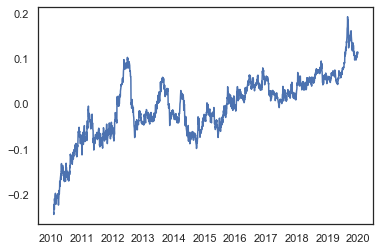

In [33]:
plt.plot(spread)

### Recurrent Neural Network:

In [34]:
LOOKBACK_WINDOW = 30
PREDICT_WINDOW = 1
BATCH_SIZE = 3   #e.g if 3, then trains with 3 samples/lookback windows, each with 15 timesteps and 2 features at once before updating gradients.
HIDDEN = 64
DROPOUT = 0.3
OPTIMIZER = 'adam'
EPOCHS = 3
SEQ_LEN = 60  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
NB_SAMPLES=180

In [35]:
import keras.callbacks
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dense, Dropout
from keras.layers.recurrent import LSTM
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy.random as random

In [36]:
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

In [37]:
def prep_feature_data(X,Y):
    data = np.column_stack([X,Y])
    scaler = MinMaxScaler(feature_range=(-1,1))
    data = scaler.fit_transform(data)
    return data
 
#format features for the model into a multidimensional array
data1 = prep_feature_data(x1,y1)[-121:]
data2 = prep_feature_data(x1,y1)#[-91:]


In [39]:
def window_stop(data,LOOKBACK_WINDOW,PREDICT_WINDOW):
    examples = LOOKBACK_WINDOW
    y_examples = PREDICT_WINDOW
    nb_samples = len(data) - examples - y_examples #makes sure it can be split into lookback windows properly

    return nb_samples
 
#ensure it can be divided into the lookback window/batch size
nb_samples1 = window_stop(data1,LOOKBACK_WINDOW,PREDICT_WINDOW)
nb_samples2 = window_stop(data2,LOOKBACK_WINDOW,PREDICT_WINDOW)

In [41]:
def input_features(nb_samples,LOOKBACK_WINDOW,data):
    input_list = [np.expand_dims(data[i:LOOKBACK_WINDOW+i,:], axis=0) for i in range(nb_samples)] #here nb_samples comes in handy
    input_mat = np.concatenate(input_list, axis=0)

    return input_mat
 
#format the features into the batch size
input_mat1 = input_features(nb_samples1,LOOKBACK_WINDOW,data1)
input_mat2 = input_features(nb_samples2,LOOKBACK_WINDOW,data2)

In [43]:
def target_values(input_mat):
    targets = []
    for i in range(len(input_mat)):
        X1 = input_mat[i].T[0]
        X2 = input_mat[i].T[1]
        beta = np.polyfit(X1,X2,1)[0] #the slope is calculated from each lookback window 
        targets=np.append(targets,X1[-1] - beta*X2[-1]) 
        targets = np.array(targets)

    return targets
 
#format the targets into the batch size
targets1 = target_values(input_mat1)
targets2 = target_values(input_mat2)

In [45]:
def basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat,targets):
    num_features = input_mat.shape[2] #this is the same as input dimension, used in describing batch_input_shape

    model = Sequential()

    model.add(LSTM(HIDDEN,batch_input_shape=(BATCH_SIZE,LOOKBACK_WINDOW,num_features)))
    model.add(Dropout(DROPOUT))
    model.add(Dense(1)) #the output is one dimensional

    model.compile(loss='mse',optimizer=OPTIMIZER)
    history = LossHistory()

    predictions,actuals,scores = [],[],[]

    assert(len(input_mat)==len(targets)) #checks each sample has a corresponding target value 

    for i in range(1,len(input_mat)):
        trainX = input_mat[0:i]
        trainY = targets[0:i]
        testX = input_mat[i].reshape(1,input_mat[0].shape[0],input_mat[0].shape[1]) #convert the input into 3 dimensional array
        testY = np.array([targets[i]]).reshape(1,1) #convert the target value into a 2 dimensional array

        #walk forward training, to predict the next timestep 
        #you can adjust the verbose parameter to 1 or 2 to watch the LSTM's progress 
        model.fit(trainX,trainY,nb_epoch=EPOCHS,batch_size=BATCH_SIZE,callbacks=[history],verbose=1)
        prediction = model.predict(testX,batch_size=BATCH_SIZE) 
        score = model.evaluate(testX,testY,batch_size=BATCH_SIZE,verbose=0)

        predictions.append(prediction[0][0])
        actuals.append(targets[i])
        scores.append(score)

    return model,history,predictions,actuals,scores

In [46]:
def evaluate_walk_forward_LSTM(model,history,predictions,actuals,scores):
    print(np.mean(scores[int(len(scores)*0.75):])) #since the latter predictions have been trained on more data, we take the average of the testing loss scores for the last quarter of predictions

    plt.figure(1)
    plt.plot(history.losses)
    plt.title('Loss History')
    plt.figure(2)
    plt.plot(scores)
    plt.title('Testing Loss')
    plt.figure(3)
    plt.plot(actuals,'b-',label='actual')
    plt.plot(predictions,'g-',label='prediction')
    plt.title('Basic LSTM')
    plt.legend()
    plt.grid('on')
    plt.show()

/Users/principal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Epoch 1/3
1/1 [==============================] - 1s 597ms/step - loss: 0.2420
Epoch 2/3
1/1 [==============================] - 0s 31ms/step - loss: 0.0515
Epoch 3/3
1/1 [==============================] - 0s 25ms/step - loss: 0.1123
Epoch 1/3
2/2 [==============================] - 0s 25ms/step - loss: 0.0253
Epoch 2/3
2/2 [==============================] - 0s 22ms/step - loss: 0.0339
Epoch 3/3
2/2 [==============================] - 0s 21ms/step - loss: 0.0455
Epoch 1/3
3/3 [==============================] - 0s 20ms/step - loss: 0.0441
Epoch 2/3
3/3 [==============================] - 0s 21ms/step - loss: 0.0213
Epoch 3/3
3/3 [==============================] - 0s 23ms/step - loss: 0.0279
Epoch 1/3
4/4 [==============================] - 0s 20ms/step - loss: 0.0325
Epoch 2/3
4/4 [==============================] - 0s 25ms/step - loss: 0.0173
Epoch 3/3
4/4 [==============================] - 0s 20ms/step - loss: 0.0173
Epoch 1/3
5/5 [==============================] - 0s 25ms/step - loss: 0.026

70/70 [==============================] - 2s 25ms/step - loss: 0.0313
Epoch 2/3
70/70 [==============================] - 1s 20ms/step - loss: 0.0341
Epoch 3/3
70/70 [==============================] - 2s 21ms/step - loss: 0.0345
Epoch 1/3
71/71 [==============================] - 1s 20ms/step - loss: 0.0345
Epoch 2/3
71/71 [==============================] - 1s 19ms/step - loss: 0.0355
Epoch 3/3
71/71 [==============================] - 1s 20ms/step - loss: 0.0327
Epoch 1/3
72/72 [==============================] - 2s 26ms/step - loss: 0.0344
Epoch 2/3
72/72 [==============================] - 1s 20ms/step - loss: 0.0348
Epoch 3/3
72/72 [==============================] - 1s 20ms/step - loss: 0.0355
Epoch 1/3
73/73 [==============================] - 1s 20ms/step - loss: 0.0364
Epoch 2/3
73/73 [==============================] - 2s 21ms/step - loss: 0.0363
Epoch 3/3
73/73 [==============================] - 1s 20ms/step - loss: 0.0369
Epoch 1/3
74/74 [==============================] - 1s 19ms/ste

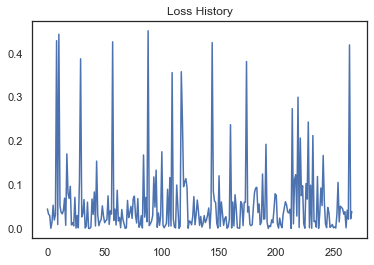

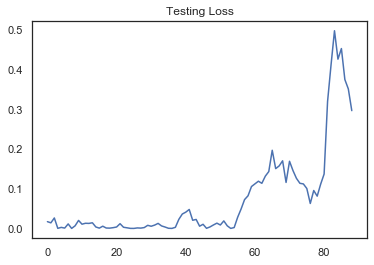

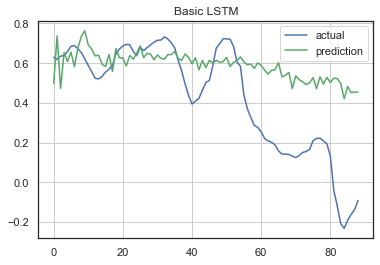

In [47]:
LOOKBACK_WINDOW = 30
PREDICT_WINDOW = 1
BATCH_SIZE = 1 #e.g if 3, then trains with 3 samples/lookback windows, each with 15 timesteps and 2 features at once.
HIDDEN = 64
DROPOUT = 0.3
OPTIMIZER = 'adam'
EPOCHS = 3
 
model1,history1,predictions1,actuals1,scores1 = basic_LSTM_model(BATCH_SIZE,HIDDEN,LOOKBACK_WINDOW,DROPOUT,OPTIMIZER,EPOCHS,input_mat1,targets1)
evaluate_walk_forward_LSTM(model1,history1,predictions1,actuals1,scores1)

In [48]:
Total = [0]*len(targets2)
j=0
for i in range(0,(len(targets2)-len(predictions1))):
    Total[i]= targets2[i]
for i in range((len(targets2)-len(predictions1)),len(targets2)):
    Total[i]=predictions1[j]
    j+=1

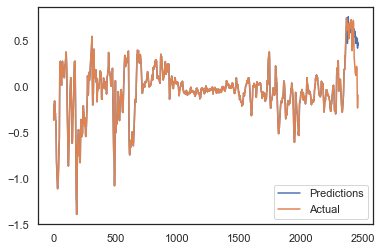

In [49]:
plt.plot(Total,label='Predictions')
plt.plot(targets2,label='Actual')
plt.legend(loc='best')
plt.show(block=False)

0.9708172164235908

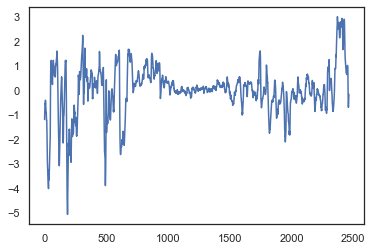

In [50]:
#Normalized predictions:
std=np.std(targets2)
mu=np.mean(targets2)
zscore=(targets2-mu)/std
plt.plot(zscore)
open_threshold=2
close_threshold=0.5
stop_loss_threshold=3
initial_wealth=100
window=5
S1=x1
S2=y1
model = sm.OLS(S1, S2)
results = model.fit()
b = results.params[0]
b

## Stationarity test:

In [51]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    #rolmean = pd.rolling_mean(timeseries, window=12)
    #rolstd = pd.rolling_std(timeseries, window=12)
    rolmean = pd.Series(timeseries).rolling(window=10).mean()
    rolstd = pd.Series(timeseries).rolling(window=10).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

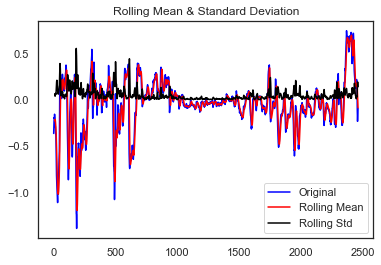

Results of Dickey-Fuller Test:
Test Statistic                -5.824893e+00
p-value                        4.101129e-07
#Lags Used                     1.900000e+01
Number of Observations Used    2.445000e+03
Critical Value (1%)           -3.433027e+00
Critical Value (5%)           -2.862723e+00
Critical Value (10%)          -2.567400e+00
dtype: float64


In [52]:
test_stationarity(targets2)

## Fourier fitting - spectral analysis:

In [53]:
import datetime
import numpy as np
import scipy as sp
import scipy.fftpack
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [54]:
res=Total-np.mean(Total)

In [55]:
temp=[res[i] for i in range(0,len(Total))]
temp_fft = sp.fftpack.fft(temp)
temp_psd = np.abs(temp_fft) ** 2
fftfreq = sp.fftpack.fftfreq(len(temp_psd),1/10)
i = fftfreq > 0
temp_fft_bis = temp_fft.copy()
temp_fft_bis[np.abs(fftfreq) > 1.1] = 0
temp_slow = np.real(sp.fftpack.ifft(temp_fft_bis))

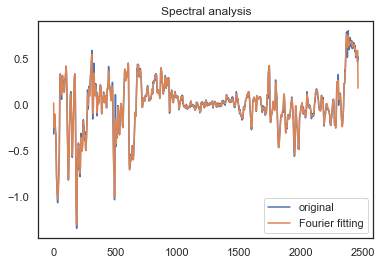

In [56]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
p1, = plt.plot(res,label='original')
p2, = plt.plot(range(0,len(temp_slow)),temp_slow,label="Fourier fitting")
plt.legend(loc='best')
plt.title('Spectral analysis')
plt.show()

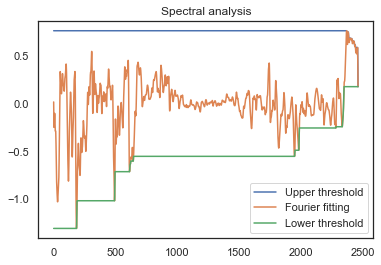

In [57]:
## Threshold search:
temp_slow
upper_threshold=[max(temp_slow[t:]) for t in range(len(temp_slow))]
lower_threshold=[min(temp_slow[t:]) for t in range(len(temp_slow))]
fig = plt.figure()
ax1 = fig.add_subplot(111)
p1, = plt.plot(range(0,len(temp_slow)),upper_threshold,label='Upper threshold')
p2, = plt.plot(range(0,len(temp_slow)),temp_slow,label="Fourier fitting")
p3, = plt.plot(range(0,len(temp_slow)),lower_threshold,label='Lower threshold')
plt.legend(loc='best')
plt.title('Spectral analysis')
plt.show()

In [58]:
#Pairs trading:
# Trade using a simple strategy
def spectral_trade(upper_threshold,lower_threshold):
    #open_threshold,close_threshold,stop_loss_threshold=thresholds
    #print(thresholds)
    # Simulate trading
    wealth = 100
    open_pos = False
    long=0
    shorting_time_1=0
    shorting_time_2=0
    stop_loss_threshold = max(max(upper_threshold),max(lower_threshold))+0.7
    j=0
    for t in range((len(targets2)-len(predictions1)),len(targets2)):
        up_threshold=upper_threshold[t]
        down_threshold=lower_threshold[t]
        if zscore[t]< down_threshold and open_pos==False:
            open_pos=True
            n_short=wealth*b/S1[t]
            amount_shorting=n_short*S1[t]
            n_long=(wealth+amount_shorting)/S2[t]
            shorting_time_1=t
            long=1
            #print('Opening position, Longing asset  %s, wealth_open= %s, opening time= %s '%(long,wealth_open,t))
    
        elif zscore[t]> up_threshold and open_pos==False:
            open_pos=True
            n_short=wealth/S2[t]
            amount_shorting=n_short*S2[t]
            n_long=(wealth+amount_shorting)/(b*S1[t])
            shorting_time_2=t
            long=2
            #print('Opening position, Longing asset  %s, wealth_open= %s, opening time= %s'%(long,wealth_open,t))
    
        elif zscore[t] < up_threshold and open_pos==True and long==2:
            open_pos=False
            wealth=(n_long*S1[t]-(n_short*(S2[t])))
            closing_time=t
            #print(j,'3')
            #print(wealth)
            #print('Closing position, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
    
        elif zscore[t] > down_threshold and open_pos==True and long==1:
            open_pos=False
            wealth=(n_long*S2[t]-(n_short*(S1[t])))
            closing_time=t
            #print(j,'4')
            #print(wealth)
            #print('Closing position, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
    
        elif (zscore[t])<= - stop_loss_threshold and open_pos==True and long==1:
            open_pos=False
            wealth=(n_long*S2[t]-(n_short*(S1[t])))
            closing_time=t
            #print(j,'5')
            #print(wealth)
            #print('Closing position, Stop loss, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
        
        elif (zscore[t])>= stop_loss_threshold and open_pos==True and long==2:
            open_pos=False
            wealth=(n_long*S1[t]-(n_short*(S2[t])))
            closing_time=t
            #print(j,'6')
            #print(wealth)
            #print('Closing position, Stop loss, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
    
        elif t==(len(targets2)-1) and open_pos==True and long==1:
            open_pos=False
            wealth=(n_long*S2[t]-(n_short*(S1[t])))
            closing_time=t
            #print(j,'7')
            #print(wealth)
            #print('Closing position, last day, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
        
        elif t==(len(targets2)-1) and open_pos==True and long==2:
            open_pos=False
            wealth=(n_long*S1[t]-(n_short*(S2[t])))
            closing_time=t
            #print(j,'8')
            #print(wealth)
            #print('Closing position, last day, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
        j=j+1
    return wealth

In [59]:
final_wealth=spectral_trade(upper_threshold,lower_threshold)
profit=(final_wealth-initial_wealth)/initial_wealth
profit
final_wealth

1 6
105.82715134347102
3 6
112.24641650271757
5 6
119.35837299785734
7 6
126.56225346583227
9 6
134.16700284984196
11 6
142.85631011532354
13 6
151.17175797598432
15 6
161.27875445036076
17 6
171.65928344949836
19 6
182.04613233282757
21 6
193.3164990636958
23 6
205.29316575884005
25 6
218.56561162782447
27 6
232.54933118778487
29 6
247.2731403237469
31 6
262.3192967567163
33 6
279.5158949649228
35 6
296.6550872949761
37 6
316.0450111163821
39 6
332.7672962143045
41 6
348.1361785151987
43 6
370.26642317574454
45 6
392.2330740337276
47 6
417.75963098818346
49 6
443.3904594069999
51 6
470.3753495723892
53 6
499.8366745402844
55 6
527.544691805029
81 3
551.4926838794446
88 7
552.6609716282076


552.6609716282076

### Bayesian optimization:

In [60]:
def bayesian_trade(thresholds):
    open_threshold,close_threshold,stop_loss_threshold=thresholds
    #print(thresholds)
    # Simulate trading
    wealth = initial_wealth
    open_pos = False
    long=0
    new_wealth=0
    shorting_time_1=0
    shorting_time_2=0
    for t in range(len(targets2)):
        if zscore[t] < -open_threshold and zscore[t]>-stop_loss_threshold and open_pos==False:
            open_pos=True
            n_short=wealth*b/S1[t]
            amount_shorting=n_short*S1[t]
            n_long=(wealth+amount_shorting)/S2[t]
            shorting_time_1=t
            long=1
            #print(t)
            #print('Short S1 %s, Amount from shorting S1 %s , Long S2 %s '%(n_short,amount_shorting))
    
        elif zscore[t] > open_threshold and  zscore[t]< stop_loss_threshold and open_pos==False:
            open_pos=True
            n_short=wealth/S2[t]
            amount_shorting=n_short*S2[t]
            n_long=(wealth+amount_shorting)/(b*S1[t])
            shorting_time_2=t
            long=2
            #print(t)
            #print('Short S2 %s, Amount from shorting S2 %s , Long S1 %s '%(n_short,amount_shorting,n_long))
            #print('Opening position, Longing asset  %s, wealth_open= %s, opening time= %s'%(long,wealth_open,t))
    
        elif open_pos==True and zscore[t]< close_threshold and long==2:
            open_pos=False
            wealth=(n_long*S2[t]-(n_short*(S1[t])))
            closing_time=t
            #print(t)
            #print('Price Long Position t-1 %s, Price Long Position t %s' %(S2[shorting_time_1],S2[t]))
            #print('Total sell S2 %s, Price t-1 %s, Price t %s, Gaining on S1 %s ,Wealth %s '%(n_long*S2[t],S1[shorting_time_1],S1[t],(n_short*(S1[shorting_time_1]-S1[t])),wealth))
            #print('Closing position, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
    
        elif zscore[t] > -close_threshold and open_pos==True and long==1:
            open_pos=False
            wealth=(n_long*S1[t]-(n_short*(S2[t])))
            closing_time=t
            #print(t)
            #print('Price Long Position t-1 %s, Price Long Position t %s' %(S1[shorting_time_2],S1[t]))
            #print('Total sell S1 %s, Price t-1 %s, Price t %s, Gaining on S2 %s ,Wealth %s '%(n_long*S1[t],S2[shorting_time_2],S2[t],(n_short*(S2[shorting_time_1]-S2[t])),wealth))
            #print('Closing position, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
    
        elif (zscore[t])<= - stop_loss_threshold and open_pos==True and long==1:
            open_pos=False
            wealth=(n_long*S2[t]-(n_short*(S1[t])))
            closing_time=t
            #print('Price Long Position t-1 %s, Price Long Position t %s' %(S2[shorting_time_1],S2[t]))
            #print('Total sell S2 %s, Price t-1 %s, Price t %s, Gaining on S1 %s ,Wealth %s '%(n_long*S2[t],S1[shorting_time_1],S1[t],(n_short*(S1[shorting_time_1]-S1[t])),wealth))
            #print('Closing position, Stop loss, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
        
        elif (zscore[t])>= stop_loss_threshold and open_pos==True and long==2:
            open_pos=False
            wealth=(n_long*S1[t]-(n_short*(S2[t])))
            closing_time=t
            #print(t)
            #print('Price Long Position t-1 %s, Price Long Position t %s' %(S1[shorting_time_2],S1[t]))
            #print('Total sell S1 %s, Price t-1 %s, Price t %s, Gaining on S2 %s ,Wealth %s '%(n_long*S1[t],S2[shorting_time_2],S2[t],(n_short*(S2[shorting_time_1]-S2[t])),wealth))
            #print('Closing position, Stop loss, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
    
        elif t==(len(targets2)-1) and open_pos==True and long==1:
            open_pos=False
            wealth=(n_long*S2[t]-(n_short*(S1[t])))
            closing_time=t
            #print(t)
            #print('Price Long Position t-1 %s, Price Long Position t %s' %(S2[shorting_time_1],S2[t]))
            #print('Total sell S2 %s, Price t-1 %s, Price t %s, Gaining on S1 %s ,Wealth %s '%(n_long*S2[t],S1[shorting_time_1],S1[t],(n_short*(S1[shorting_time_1]-S1[t])),wealth))
            #print('Closing position, last day, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
        
        elif t==(len(targets2)-1) and open_pos==True and long==2:
            open_pos=False
            wealth=(n_long*S1[t]-(n_short*(S2[t])))
            closing_time=t
            #print(t)
            #print('Price Long Position t-1 %s, Price Long Position t %s' %(S1[shorting_time_2],S1[t]))
            #print('Total sell S1 %s, Price t-1 %s, Price t %s, Gaining on S2 %s ,Wealth %s '%(n_long*S1[t],S2[shorting_time_2],S2[t],(n_short*(S2[shorting_time_1]-S2[t])),wealth))
            #print('Closing position, last day, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
    return -wealth

#final_wealth=-trade([open_threshold,close_threshold])
#profit=(final_wealth-initial_wealth)/initial_wealth
#profit
#final_wealth

In [61]:
from hyperopt import hp
# Create the domain space
space = [hp.uniform('x', 0, 1),hp.uniform('y',0,2),hp.uniform('z',2,4)]

from hyperopt import tpe
# Create the algorithm
tpe_algo = tpe.suggest

from hyperopt import Trials
# Create a trials object
tpe_trials = Trials()

from hyperopt import fmin

# Run 2000 evals with the tpe algorithm
tpe_best = fmin(fn=bayesian_trade, space=space, 
                algo=tpe_algo, trials=tpe_trials, 
                max_evals=1000)

print(tpe_best)

100%|██████████| 1000/1000 [02:24<00:00,  6.90trial/s, best loss: -1.1006976514843542e+25]
{'x': 0.002324856535842905, 'y': 1.70759598392384, 'z': 2.724493224013949}


#### Optimal tresholds:

In [62]:

close_threshold=tpe_best['x']
open_threshold=tpe_best['y']
stop_loss_threshold=tpe_best['z']
thresholds=open_threshold,close_threshold,stop_loss_threshold

In [63]:
def train_trade(thresholds):
    open_threshold,close_threshold,stop_loss_threshold=thresholds
    #print(thresholds)
    # Simulate trading
    wealth = 100
    open_pos = False
    long=0
    new_wealth=0
    shorting_time_1=0
    shorting_time_2=0
    j=0
    for t in range((len(targets2)-len(predictions1)),len(targets2)):
        if zscore[t] < -open_threshold and zscore[t]>-stop_loss_threshold and open_pos==False:
            open_pos=True
            n_short=wealth*b/S1[t]
            amount_shorting=n_short*S1[t]
            n_long=(wealth+amount_shorting)/S2[t]
            shorting_time_1=t
            long=1
            #print(j)
            #print('Short S1 %s, Amount from shorting S1 %s , Long S2 %s '%(n_short,amount_shorting))
    
        elif zscore[t] > open_threshold and  zscore[t]< stop_loss_threshold and open_pos==False:
            open_pos=True
            n_short=wealth/S2[t]
            amount_shorting=n_short*S2[t]
            n_long=(wealth+amount_shorting)/(b*S1[t])
            shorting_time_2=t
            long=2
            #print(j)
            #print('Short S2 %s, Amount from shorting S2 %s , Long S1 %s '%(n_short,amount_shorting,n_long))
            #print('Opening position, Longing asset  %s, wealth_open= %s, opening time= %s'%(long,wealth_open,t))
    
        elif zscore[t]< close_threshold and open_pos==True and long==2:
            open_pos=False
            wealth=(n_long*S2[t]-(n_short*S1[t]))
            closing_time=t
            #print(j)
            #print(wealth)
            #print('Price Long Position t-1 %s, Price Long Position t %s' %(S2[shorting_time_1],S2[t]))
            #print('Total sell S2 %s, Price t-1 %s, Price t %s, Gaining on S1 %s ,Wealth %s '%(n_long*S2[t],S1[shorting_time_1],S1[t],(n_short*(S1[shorting_time_1]-S1[t])),wealth))
            #print('Closing position, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
    
        elif zscore[t] > -close_threshold and open_pos==True and long==1:
            open_pos=False
            wealth=n_long*S1[t]-(n_short*(S2[t]))
            closing_time=t
            #print(j)
            #print(wealth)
           #print('Price Long Position t-1 %s, Price Long Position t %s' %(S1[shorting_time_2],S1[t]))
            #print('Total sell S1 %s, Price t-1 %s, Price t %s, Gaining on S2 %s ,Wealth %s '%(n_long*S1[t],S2[shorting_time_2],S2[t],(n_short*(S2[shorting_time_1]-S2[t])),wealth))
            #print('Closing position, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
    
        elif (zscore[t])<= - stop_loss_threshold and open_pos==True and long==1:
            open_pos=False
            wealth=(n_long*S2[t]-(n_short*(S1[t])))
            closing_time=t
           # print(j)
            #print(wealth)
            #print('Price Long Position t-1 %s, Price Long Position t %s' %(S2[shorting_time_1],S2[t]))
            #print('Total sell S2 %s, Price t-1 %s, Price t %s, Gaining on S1 %s ,Wealth %s '%(n_long*S2[t],S1[shorting_time_1],S1[t],(n_short*(S1[shorting_time_1]-S1[t])),wealth))
            #print('Closing position, Stop loss, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
        
        elif (zscore[t])>= stop_loss_threshold and open_pos==True and long==2:
            open_pos=False
            wealth=(n_long*S1[t]-(n_short*(S2[t])))
            closing_time=t
            #print(j)
            #print(wealth)
            #print('Price Long Position t-1 %s, Price Long Position t %s' %(S1[shorting_time_2],S1[t]))
            #print('Total sell S1 %s, Price t-1 %s, Price t %s, Gaining on S2 %s ,Wealth %s '%(n_long*S1[t],S2[shorting_time_2],S2[t],(n_short*(S2[shorting_time_1]-S2[t])),wealth))
            #print('Closing position, Stop loss, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
    
        elif t==(len(targets2)-1) and open_pos==True and long==1:
            open_pos=False
            wealth=(n_long*S2[t]-(n_short*(S1[t])))
            closing_time=t
            #print(j)
            #print(wealth)
            #print('Price Long Position t-1 %s, Price Long Position t %s' %(S2[shorting_time_1],S2[t]))
            #print('Total sell S2 %s, Price t-1 %s, Price t %s, Gaining on S1 %s ,Wealth %s '%(n_long*S2[t],S1[shorting_time_1],S1[t],(n_short*(S1[shorting_time_1]-S1[t])),wealth))
            #print('Closing position, last day, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
        
        elif t==(len(targets2)-1) and open_pos==True and long==2:
            open_pos=False
            wealth=(n_long*S1[t]-(n_short*(S2[t])))
            closing_time=t
            #print(j)
            #print(wealth)
            #print('Price Long Position t-1 %s, Price Long Position t %s' %(S1[shorting_time_2],S1[t]))
            #print('Total sell S1 %s, Price t-1 %s, Price t %s, Gaining on S2 %s ,Wealth %s '%(n_long*S1[t],S2[shorting_time_2],S2[t],(n_short*(S2[shorting_time_1]-S2[t])),wealth))
            #print('Closing position, last day, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
        j+=1
    return wealth

In [64]:
def plot_test(spread, buy, close, stop):
    fig,ax = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 3]})
    # Calculate the spread and other thresholds
    spread1 = spread
    mean_spread = spread1.mean()
    buy          = buy
    neg_buy      = -buy
    close        = close
    neg_clo      = -close
    stop_loss    = stop
    neg_stop_loss= -stop
    
    # Plot the 2nd subplot
    sns.lineplot(data=spread1, color='#85929E', linewidth=1.2)

    ax[1].axhline(buy,   color='b', ls='--', linewidth=1, label='open_th')
    ax[1].axhline(neg_buy,   color='b', ls='--', linewidth=1, label='open_th')
    ax[1].axhline(stop_loss, color='y', ls='--', linewidth=1, label='stop_loss')
    ax[1].axhline(neg_stop_loss, color='y', ls='--', linewidth=1, label='stop_loss')
    ax[1].axhline(close,color='r', ls='--', linewidth=1, label='close_th')
    ax[1].axhline(neg_clo,color='r', ls='--', linewidth=1, label='close_th')

    #ax[1].fill_between(idx, sell_th, buy_th, facecolors='r', alpha=0.3)
    ax[1].legend(loc='best', labels=['Spread', 'open_th', 'close_th', 'stop_loss'], prop={'size':6.5})
    

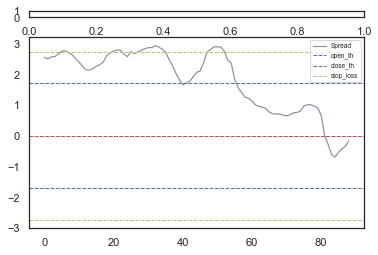

In [65]:
#Spread plot
plot_test(zscore[-len(predictions1):], open_threshold,close_threshold,stop_loss_threshold)

In [66]:
final_wealth=train_trade(thresholds)
profit=(final_wealth-initial_wealth)/initial_wealth
profit
final_wealth

0
5
106.73435166650067
7
20
114.84192179212734
23
25
122.31290811210515
26
27
130.13842738233396
36
48
135.73608549238472
53
82
142.07300409083587


142.07300409083587

### Performance metrics:

In [72]:
def trade_metrics(thresholds):
    open_threshold,close_threshold,stop_loss_threshold=thresholds
    #print(thresholds)
    # Simulate trading
    wealth = 100
    open_pos = False
    long=0
    new_wealth=0
    shorting_time_1=0
    shorting_time_2=0
    current_wealth=[]
    current_wealth.append(wealth)
    j=0
    for t in range((len(targets2)-len(predictions1)),len(targets2)):
        if zscore[t] < -open_threshold and zscore[t]>-stop_loss_threshold and open_pos==False:
            open_pos=True
            n_short=wealth*b/S1[t]
            amount_shorting=n_short*S1[t]
            n_long=(wealth+amount_shorting)/S2[t]
            shorting_time_1=t
            long=1
            current_wealth.append(wealth+amount_shorting)
            #print(j)
            #print('Short S1 %s, Amount from shorting S1 %s , Long S2 %s '%(n_short,amount_shorting))
    
        elif zscore[t] > open_threshold and  zscore[t]< stop_loss_threshold and open_pos==False:
            open_pos=True
            n_short=wealth/S2[t]
            amount_shorting=n_short*S2[t]
            n_long=(wealth+amount_shorting)/(b*S1[t])
            shorting_time_2=t
            long=2
            current_wealth.append(wealth+amount_shorting)
            #print(j)
            #print('Short S2 %s, Amount from shorting S2 %s , Long S1 %s '%(n_short,amount_shorting,n_long))
            #print('Opening position, Longing asset  %s, wealth_open= %s, opening time= %s'%(long,wealth_open,t))
    
        elif zscore[t]< close_threshold and open_pos==True and long==2:
            open_pos=False
            wealth=(n_long*S2[t]-(n_short*S1[t]))
            closing_time=t
            current_wealth.append(wealth)
            #print(j)
            #print(wealth)
            #print('Price Long Position t-1 %s, Price Long Position t %s' %(S2[shorting_time_1],S2[t]))
            #print('Total sell S2 %s, Price t-1 %s, Price t %s, Gaining on S1 %s ,Wealth %s '%(n_long*S2[t],S1[shorting_time_1],S1[t],(n_short*(S1[shorting_time_1]-S1[t])),wealth))
            #print('Closing position, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
    
        elif zscore[t] > -close_threshold and open_pos==True and long==1:
            open_pos=False
            wealth=n_long*S1[t]-(n_short*(S2[t]))
            closing_time=t
            current_wealth.append(wealth)
            #print(j)
            #print(wealth)
           #print('Price Long Position t-1 %s, Price Long Position t %s' %(S1[shorting_time_2],S1[t]))
            #print('Total sell S1 %s, Price t-1 %s, Price t %s, Gaining on S2 %s ,Wealth %s '%(n_long*S1[t],S2[shorting_time_2],S2[t],(n_short*(S2[shorting_time_1]-S2[t])),wealth))
            #print('Closing position, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
    
        elif (zscore[t])<= - stop_loss_threshold and open_pos==True and long==1:
            open_pos=False
            wealth=(n_long*S2[t]-(n_short*(S1[t])))
            closing_time=t
            current_wealth.append(wealth)
           # print(j)
            #print(wealth)
            #print('Price Long Position t-1 %s, Price Long Position t %s' %(S2[shorting_time_1],S2[t]))
            #print('Total sell S2 %s, Price t-1 %s, Price t %s, Gaining on S1 %s ,Wealth %s '%(n_long*S2[t],S1[shorting_time_1],S1[t],(n_short*(S1[shorting_time_1]-S1[t])),wealth))
            #print('Closing position, Stop loss, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
        
        elif (zscore[t])>= stop_loss_threshold and open_pos==True and long==2:
            open_pos=False
            wealth=(n_long*S1[t]-(n_short*(S2[t])))
            closing_time=t
            current_wealth.append(wealth)
            #print(j)
            #print(wealth)
            #print('Price Long Position t-1 %s, Price Long Position t %s' %(S1[shorting_time_2],S1[t]))
            #print('Total sell S1 %s, Price t-1 %s, Price t %s, Gaining on S2 %s ,Wealth %s '%(n_long*S1[t],S2[shorting_time_2],S2[t],(n_short*(S2[shorting_time_1]-S2[t])),wealth))
            #print('Closing position, Stop loss, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
    
        elif t==(len(targets2)-1) and open_pos==True and long==1:
            open_pos=False
            wealth=(n_long*S2[t]-(n_short*(S1[t])))
            closing_time=t
            #print(j)
            #print(wealth)
            current_wealth.append(wealth)
            #print('Price Long Position t-1 %s, Price Long Position t %s' %(S2[shorting_time_1],S2[t]))
            #print('Total sell S2 %s, Price t-1 %s, Price t %s, Gaining on S1 %s ,Wealth %s '%(n_long*S2[t],S1[shorting_time_1],S1[t],(n_short*(S1[shorting_time_1]-S1[t])),wealth))
            #print('Closing position, last day, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
        
        elif t==(len(targets2)-1) and open_pos==True and long==2:
            open_pos=False
            wealth=(n_long*S1[t]-(n_short*(S2[t])))
            closing_time=t
            #print(j)
            #print(wealth)
            #print('Price Long Position t-1 %s, Price Long Position t %s' %(S1[shorting_time_2],S1[t]))
            #print('Total sell S1 %s, Price t-1 %s, Price t %s, Gaining on S2 %s ,Wealth %s '%(n_long*S1[t],S2[shorting_time_2],S2[t],(n_short*(S2[shorting_time_1]-S2[t])),wealth))
            #print('Closing position, last day, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
        j+=1
    return current_wealth

In [76]:
from statistics import mean 
from statistics import variance 
from math import sqrt

def metrics(initial_wealth,wealth):
    overall_return=[(wealth[t]-initial_wealth)/initial_wealth for t in range(len(wealth))]
    total_return=overall_return[-1]
    average_return=mean(overall_return)
    volatility=sqrt(variance(overall_return))
    Rf=0.03
    sharpe=(average_return-Rf)/volatility
    drop=[(overall_return[t-1]-overall_return[t])/overall_return[t-1] for t in range(1,len(wealth))]
    MDD=max(drop)
    return total_return, average_return, sharpe,volatility, MDD
    
final_wealth=trade_metrics([open_threshold,close_threshold,stop_loss_threshold])
total_return, average_return, sharpe, volatility, MDD=metrics(initial_wealth,final_wealth)
print(total_return, average_return, sharpe, volatility, MDD)

0.42073004090835864 0.7472031441747625 1.1358990220670608 0.631396920185411 0.9326564833349933


/Users/principal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':


In [74]:
#Pairs trading:
# Trade using a simple strategy
def spectral_trade(upper_threshold,lower_threshold):
    #open_threshold,close_threshold,stop_loss_threshold=thresholds
    #print(thresholds)
    # Simulate trading
    wealth = 100
    open_pos = False
    long=0
    shorting_time_1=0
    shorting_time_2=0
    stop_loss_threshold = max(max(upper_threshold),max(lower_threshold))+0.7
    j=0
    current_wealth=[]
    current_wealth.append(wealth)
    for t in range((len(targets2)-len(predictions1)),len(targets2)):
        up_threshold=upper_threshold[t]
        down_threshold=lower_threshold[t]
        if zscore[t]< down_threshold and open_pos==False:
            open_pos=True
            n_short=wealth*b/S1[t]
            amount_shorting=n_short*S1[t]
            n_long=(wealth+amount_shorting)/S2[t]
            shorting_time_1=t
            long=1
            current_wealth.append(wealth+amount_shorting)
            #print('Opening position, Longing asset  %s, wealth_open= %s, opening time= %s '%(long,wealth_open,t))
    
        elif zscore[t]> up_threshold and open_pos==False:
            open_pos=True
            n_short=wealth/S2[t]
            amount_shorting=n_short*S2[t]
            n_long=(wealth+amount_shorting)/(b*S1[t])
            shorting_time_2=t
            long=2
            current_wealth.append(wealth+amount_shorting)
            #print('Opening position, Longing asset  %s, wealth_open= %s, opening time= %s'%(long,wealth_open,t))
    
        elif zscore[t] < up_threshold and open_pos==True and long==2:
            open_pos=False
            wealth=(n_long*S1[t]-(n_short*(S2[t])))
            closing_time=t
            current_wealth.append(wealth)
            #print(j,'3')
            #print(wealth)
            #print('Closing position, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
    
        elif zscore[t] > down_threshold and open_pos==True and long==1:
            open_pos=False
            wealth=(n_long*S2[t]-(n_short*(S1[t])))
            closing_time=t
            current_wealth.append(wealth)
            #print(j,'4')
            #print(wealth)
            #print('Closing position, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
    
        elif (zscore[t])<= - stop_loss_threshold and open_pos==True and long==1:
            open_pos=False
            wealth=(n_long*S2[t]-(n_short*(S1[t])))
            closing_time=t
            current_wealth.append(wealth)
            #print(j,'5')
            #print(wealth)
            #print('Closing position, Stop loss, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
        
        elif (zscore[t])>= stop_loss_threshold and open_pos==True and long==2:
            open_pos=False
            wealth=(n_long*S1[t]-(n_short*(S2[t])))
            closing_time=t
            current_wealth.append(wealth)
            #print(j,'6')
            #print(wealth)
            #print('Closing position, Stop loss, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
    
        elif t==(len(targets2)-1) and open_pos==True and long==1:
            open_pos=False
            wealth=(n_long*S2[t]-(n_short*(S1[t])))
            closing_time=t
            current_wealth.append(wealth)
            #print(j,'7')
            #print(wealth)
            #print('Closing position, last day, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
        
        elif t==(len(targets2)-1) and open_pos==True and long==2:
            open_pos=False
            wealth=(n_long*S1[t]-(n_short*(S2[t])))
            closing_time=t
            current_wealth.append(wealth)
            #print(j,'8')
            #print(wealth)
            #print('Closing position, last day, Longing asset  %s, wealth= %s, closing time= %s'%(long,wealth,t))
        j=j+1
    return current_wealth

In [77]:
from statistics import mean 
from statistics import variance 
from math import sqrt

def metrics(initial_wealth,wealth):
    overall_return=[(wealth[t]-initial_wealth)/initial_wealth for t in range(len(wealth))]
    total_return=overall_return[-1]
    average_return=mean(overall_return)
    volatility=sqrt(variance(overall_return))
    Rf=0.03
    sharpe=(average_return-Rf)/volatility
    drop=[(overall_return[t-1]-overall_return[t])/overall_return[t-1] for t in range(1,len(wealth))]
    MDD=max(drop)
    return total_return, average_return, sharpe,volatility, MDD
    
final_wealth=spectral_trade(upper_threshold,lower_threshold)
total_return, average_return, sharpe, volatility, MDD=metrics(initial_wealth,final_wealth)
print(total_return, average_return, sharpe, volatility, MDD)

4.526609716282076 3.0777202765771 1.2076600966459219 2.5236573478263 0.9417284865652898


/Users/principal/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
